# About the Training Demo:

This demo loads the architecture with Resnet-18 backbone, copies the pre-trained weights from the (reference) author's site and re-initializes the weights of the last few layers (responsible for generating the heatmaps, offset and bounding box size regressed values). The re-initialization is using Gaussian distribution, details are in the report. The demo shall learn these final layers, keeping the weights of the backbone frozen. We have extended nntools.py's experiment class to be able to train and evaluate our model. Finally, we also demonstrate the performance using one validation image and by computing Average Precision and Average Recall scores.

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys
import random

In [2]:
sys.path.append(sys.path[0]+'/src/lib') # Library contains model creation, trainer, detector etc.

In [3]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [4]:
Dataset = get_dataset('coco', 'ctdet') # We use COCO dataset and load annotations useful for object detecion testing

In [5]:
sys.path.append(sys.path[0]+'/src/project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset) # 'fcn_opts' loads the parameters for training the neural network. 

## Loading Dataset

In [6]:
opt.data_dir = sys.path[0]+'/data/' # data folder
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=22.04s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

In this section we reduce the training set size to 2048 images. Justification for this is provided in the report.

In [7]:
all_Ids=dataset.coco.getImgIds()
print('The total size of the training set is', len(all_Ids), 'images')
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

The total size of the training set is 118287 images


In [8]:
N=2048 # Final Training set size
np.random.seed(0)
imgIds_perm=np.random.permutation(len(all_Ids))
tmp=imgIds_perm[0:N].astype(int)
tmp2=[all_Ids[t] for t in tmp]
dataset.images=tmp2
dataset.num_samples=len(dataset.images)
np.random.seed(2)
opt.num_iters = dataset.num_samples/opt.batch_size

In [9]:
all_Ids=valset.coco.getImgIds()
print('The total size of the validation set is', len(all_Ids), 'images')
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/val2017/'

The total size of the validation set is 5000 images


## Training

In [10]:
sys.path.append(sys.path[0]+"/src/project_tools")
import nntools as nt
sys.path.append(sys.path[0]+'/src/lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [11]:
# This custom class inherits the NeuralNetwork class and author's CtdetTrainer class 
# and reinitializes the weights of the final layers. It also makes requires_grad=False for the backbone, so as to train
# only the final few layers

class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
                if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param.data = 0.1*torch.randn(param.size()) # Random initialization
                else:
                    param.requires_grad=False
        self.model = model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [12]:
print('The Architecture for the demo is:', opt.arch)

The Architecture for the demo is: resdcn_18


In [13]:
model = create_model(opt.arch, opt.heads, opt.head_conv) # Create model with required architecture and random weights
model =load_model(model,sys.path[0]+'/models/ctdet_coco_resdcn18.pth'); # loading pre-trained weights
net = Centernet_model(opt,model); # Last few layers gaussian initialized
net = net.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [14]:
optimizer = torch.optim.Adam(net.parameters(), opt.lr)
stats_manager = nt.StatsManager()
exp = nt.Experiment(net,dataset,valset,optimizer,stats_manager,
output_dir="./experiments/TrainingDemo", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp.run2(num_epochs=200) # Run the experiment for 200 epochs

Start/Continue training from epoch 0


In [ ]:
plt.plot(exp.history)
plt.show()
print('The validation loss is', exp.evaluate2())

## Running Detector on one Validation image (provide absolute path for other images)

In [34]:
sys.path.append(sys.path[0]+'/src/lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [35]:
opt.load_model = sys.path[0]+'/models/ctdet_coco_resdcn18.pth'
detector = CtdetDetector(opt)
detector.model = exp.net.model # loading the above trained model
detector.model.eval();

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [41]:
# Running detector on one random validation image
results = {}
for i in range(1):
    tst_id = np.random.randint(len(valset))
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

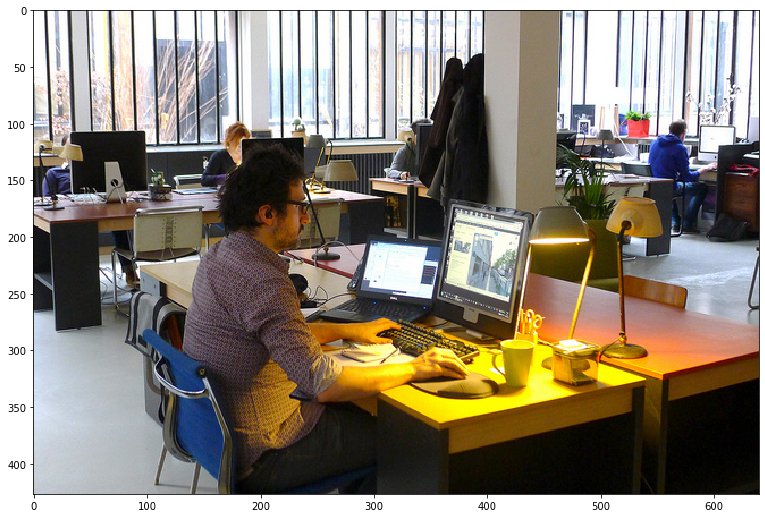

In [42]:
# Detection result on the images i.e the objects detected alongwith corresponding categories
import cv2
import skimage.io as io

coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
im_id = valset[tst_id]['meta']['img_id']
img = valset.coco.loadImgs(im_id)[0]
img_dir='~/MoDL_CenterNet/data/coco/val2017/'
f_name=img_dir
f_name+=img['file_name']
I = io.imread(f_name)
show_txt = True
for c_id in range(80):
    for j in range(ret['results'][c_id+1].shape[0]):
        if ret['results'][c_id+1][j][4]>=opt.vis_thresh:
            bbox = ret['results'][c_id+1][j]
            cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
            if show_txt:
                txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                font = cv2.FONT_HERSHEY_SIMPLEX
                cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),(int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)


fig, axes = plt.subplots(figsize=(13,13))
axes.imshow(I)
#im=np.moveaxis(im,[0,1,2],[2,0,1])
#im = im.reshape(512,512,3)
#cv2
#print(im.shape)

## Evaluating Average Precision and Average Recall scores on the entire Validation set

In [62]:
sys.path.append(sys.path[0]+'/src/lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [43]:
opt.load_model = sys.path[0]+'/models/ctdet_coco_resdcn18.pth'
detector = CtdetDetector(opt)
detector.model = exp.net.model
detector.model.eval();

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [ ]:
results = {}
for tst_id in range(len(valset)):
    if np.mod(tst_id, 100)==0:
        print('Percentage done:', 100*tst_id/len(valset))
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

Percentage done: 0.0
Percentage done: 2.0
Percentage done: 4.0
Percentage done: 6.0
Percentage done: 8.0
Percentage done: 10.0
Percentage done: 12.0
Percentage done: 14.0
Percentage done: 16.0
Percentage done: 18.0
Percentage done: 20.0
Percentage done: 22.0
Percentage done: 24.0
Percentage done: 26.0
Percentage done: 28.0
Percentage done: 30.0
Percentage done: 32.0
Percentage done: 34.0
Percentage done: 36.0
Percentage done: 38.0
Percentage done: 40.0
Percentage done: 42.0
Percentage done: 44.0
Percentage done: 46.0
Percentage done: 48.0
Percentage done: 50.0
Percentage done: 52.0
Percentage done: 54.0
Percentage done: 56.0
Percentage done: 58.0
Percentage done: 60.0
Percentage done: 62.0
Percentage done: 64.0
Percentage done: 66.0
Percentage done: 68.0
Percentage done: 70.0
Percentage done: 72.0
Percentage done: 74.0
Percentage done: 76.0
Percentage done: 78.0


In [65]:
opt.save_dir = sys.path[0]+'/experiments/TrainingDemoResults'
valset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=7.91s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=82.40s).
Accumulating evaluation results...
DONE (t=18.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=